In [1]:
from __future__ import print_function
import pandas as pd
import os
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import math
%matplotlib inline
from statsmodels.graphics import tsaplots 
import pandas as pd

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from hurst import compute_Hc

#rom pandas.io.data import DataReader
from pykalman import KalmanFilter

In [2]:
def draw_date_coloured_scatterplot(names, prices):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the 
    changing relationship between the sets of prices    
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('jet')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[names[0]], prices[names[1]], 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

In [3]:
def calc_slope_intercept_kalman(etfs, prices):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, state_covs = kf.filter(prices[etfs[1]].values)
    return state_means, state_covs

In [4]:
def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filter calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()

In [5]:
##This code runs the Dickey-Fuller Test 
# This tests for stationarity in our time-series

#define function for ADF test                                DF WORKS ONLY WHEN AR(1), ADF 
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [6]:
#Reading in Crude WTI Data
data = pd.read_csv('data.csv', parse_dates = ['Date'])
data.set_index(keys = 'Date', inplace = True)
data['WTI_MA20'] = data['WTI_1'].rolling(window=20).mean()
data['RBOB_MA20'] = data['RBOB_1'].rolling(window=20).mean() 
data = data[20:]
data.head()

WTI_1  WTI_2  WTI_4  WTI_Roll  RBOB_1  RBOB_2  RBOB_4  RBOB_Roll  \
Date                                                                           
2015-02-02  49.57  50.45  52.72         0   1.545   1.757   1.767          0   
2015-02-03  53.05  53.86  56.11         0   1.601   1.823   1.837          0   
2015-02-04  48.45  49.30  51.89         0   1.482   1.717   1.737          0   
2015-02-05  50.48  51.31  53.79         0   1.525   1.763   1.786          0   
2015-02-06  51.69  52.50  54.86         0   1.559   1.804   1.827          0   

            WTI_MA20  RBOB_MA20  
Date                             
2015-02-02   47.1695    1.34670  
2015-02-03   47.3200    1.35770  
2015-02-04   47.3460    1.36410  
2015-02-05   47.4375    1.37345  
2015-02-06   47.5825    1.38435

In [7]:
#Reading in OECD Monthly Data
from datetime import datetime

Capacity = pd.read_csv('Capacity.csv', parse_dates=['Date'])
Capacity.set_index(keys = 'Date', inplace = True)
Capacity = Capacity['Sum of Working Storage Capacity and Stocks in Transit3'].resample('D')\
                .mean()
Capacity = Capacity.interpolate()
Capacity = Capacity

Capacity = Capacity[Capacity.index.isin(data.index)]
Capacity = Capacity.dropna()

OECD = pd.read_csv('OECD_End-of-period_Commercial_Crude_Oil_and_Other_Liquids_Inventory_Monthly.csv', parse_dates = ['Month'])
OECD.set_index(keys = 'Month', inplace = True)

OECD = OECD.resample('D')\
                .mean()
OECD = OECD.interpolate()
print(OECD)

US = pd.read_csv('Weekly_U.S._Ending_Stocks_excluding_SPR_of_Crude_Oil_and_Petroleum_Products.csv', parse_dates = ['Week of'])
US.set_index(keys = 'Week of', inplace = True)
US = US.resample('D')\
                .mean()
US = US.interpolate()
US = US/1000

US = US[US.index.isin(data.index)]
OECD = OECD[OECD.index.isin(Capacity.index)]
print(US.head(4))
print(OECD.head(4))

Comm_Crude = pd.read_csv('Weekly_U.S._Ending_Stocks_excluding_SPR_of_Crude_Oil (1).csv', parse_dates = ['Week of'])
Comm_Crude.set_index(keys = 'Week of', inplace = True)
Comm_Crude = Comm_Crude.resample('D')\
                .mean()
Comm_Crude = Comm_Crude.interpolate()
Comm_Crude = Comm_Crude

Comm_Crude = Comm_Crude[Comm_Crude.index.isin(Capacity.index)]
print(Comm_Crude.head(4))

transit = pd.read_csv('Weekly_U.S._Crude_Oil_Stocks_in_Transit_(on_Ships)_from_Alaska.csv', parse_dates = ['Week of'])
transit.set_index(keys = 'Week of', inplace = True)
transit = transit.resample('D')\
                .mean()
transit = transit.interpolate()
transit = transit

transit = transit[transit.index.isin(Capacity.index)]
print(transit.head(4))


print(Capacity.head(4))

                   OECD
Month                  
2003-01-01  2476.715001
2003-01-02  2474.060130
2003-01-03  2471.405259
2003-01-04  2468.750388
2003-01-05  2466.095517
...                 ...
2022-11-27  2952.798347
2022-11-28  2951.921256
2022-11-29  2951.044166
2022-11-30  2950.167076
2022-12-01  2949.289986

[7275 rows x 1 columns]
               US Total
Week of                
2015-02-02  1138.812143
2015-02-03  1139.049857
2015-02-04  1139.287571
2015-02-05  1139.525286
                   OECD
Month                  
2015-02-02  2719.229138
2015-02-03  2721.224764
2015-02-04  2723.220389
2015-02-05  2725.216014
               Comm Crude
Week of                  
2015-02-02  381327.428571
2015-02-03  381945.571429
2015-02-04  382563.714286
2015-02-05  383181.857143
                 Alaska
Week of                
2015-02-02  4151.714286
2015-02-03  4161.285714
2015-02-04  4170.857143
2015-02-05  4180.428571
Date
2015-02-02    637633.170330
2015-02-03    637855.307692
2015-02-04    

Date
2015-02-02    0.604547
2015-02-03    0.605320
2015-02-04    0.606093
2015-02-05    0.606866
2015-02-06    0.607638
                ...   
2020-03-25    0.591000
2020-03-26    0.593436
2020-03-27    0.595871
2020-03-30    0.603922
2020-03-31    0.606605
Name: I/C, Length: 1288, dtype: float64
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


Text(0.5, 0, 'I/C')

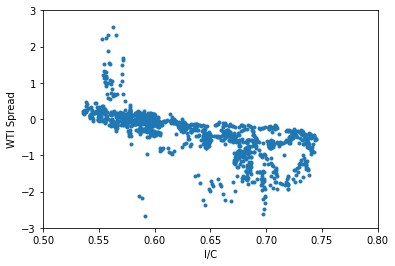

In [8]:
#df = np.divide(OECD,US)
#df = np.multiply(Crude_inventory, np.asarray(df))
df = pd.concat([data['WTI_1'], data['WTI_2']], axis = 1)
df['WTI_Spread'] = df['WTI_1'] - df['WTI_2']
#df['Inventory Change'] = df['US Crude'] - df['US Crude'].shift(-1)
df['I'] = np.add(transit, Comm_Crude)
df['C'] = Capacity
df = df.dropna()
df['I/C'] = np.divide(df['I'],df['C'])
#data = data[data.index.isin(df.index)]
df['WTI_Roll'] = data['WTI_Roll']
df['I/C_MA10'] = df['I/C'].rolling(window=10).mean()
print(df['I/C'])
plt.plot(df['I/C'],df['WTI_Spread'], '.')
plt.ylim(-3, 3)
plt.xlim(0.5,0.8)
plt.ylabel('WTI Spread')
plt.xlabel('I/C')

In [9]:
df['I/C_dev'] = 100*(df['I/C'] - df['I/C_MA10'])
df

WTI_1  WTI_2  WTI_Spread              I              C       I/C  \
Date                                                                           
2015-02-02  49.57  50.45       -0.88  385479.142857  637633.170330  0.604547   
2015-02-03  53.05  53.86       -0.81  386106.857143  637855.307692  0.605320   
2015-02-04  48.45  49.30       -0.85  386734.571429  638077.445055  0.606093   
2015-02-05  50.48  51.31       -0.83  387362.285714  638299.582418  0.606866   
2015-02-06  51.69  52.50       -0.81  387990.000000  638521.719780  0.607638   
...           ...    ...         ...            ...            ...       ...   
2020-03-25  24.49  27.16       -2.67  469790.142857  794906.688525  0.591000   
2020-03-26  22.60  25.71       -3.11  471792.571429  795018.573770  0.593436   
2020-03-27  21.51  25.15       -3.64  473795.000000  795130.459016  0.595871   
2020-03-30  20.09  24.09       -4.00  480399.714286  795466.114754  0.603922   
2020-03-31  20.48  24.51       -4.03  482601.285714  795578.000000  0.606605   

            WTI_Roll  I/C_MA10   I/C_dev  
Date                                      
2015-02-02         0       NaN       NaN  
2015-02-03         0       NaN       NaN  
2015-02-04         0       NaN       NaN  
2015-02-05         0       NaN       NaN  
2015-02-06         0       NaN       NaN  
...              ...       ...       ...  
2020-03-25         0  0.581370  0.963051  
2020-03-26         0  0.582962  1.047366  
2020-03-27         0  0.584766  1.110468  
2020-03-30         0  0.587333  1.658922  
2020-03-31         0  0.590154  1.645035  

[1288 rows x 9 columns]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


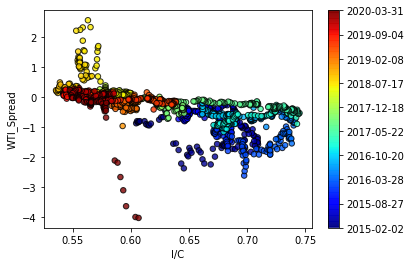

In [10]:

names = [ 'I/C','WTI_Spread']
roll_name = 'WTI_2'
good = 'WTI_1'
draw_date_coloured_scatterplot(names, df[names])

In [11]:
df

WTI_1  WTI_2  WTI_Spread              I              C       I/C  \
Date                                                                           
2015-02-02  49.57  50.45       -0.88  385479.142857  637633.170330  0.604547   
2015-02-03  53.05  53.86       -0.81  386106.857143  637855.307692  0.605320   
2015-02-04  48.45  49.30       -0.85  386734.571429  638077.445055  0.606093   
2015-02-05  50.48  51.31       -0.83  387362.285714  638299.582418  0.606866   
2015-02-06  51.69  52.50       -0.81  387990.000000  638521.719780  0.607638   
...           ...    ...         ...            ...            ...       ...   
2020-03-25  24.49  27.16       -2.67  469790.142857  794906.688525  0.591000   
2020-03-26  22.60  25.71       -3.11  471792.571429  795018.573770  0.593436   
2020-03-27  21.51  25.15       -3.64  473795.000000  795130.459016  0.595871   
2020-03-30  20.09  24.09       -4.00  480399.714286  795466.114754  0.603922   
2020-03-31  20.48  24.51       -4.03  482601.285714  795578.000000  0.606605   

            WTI_Roll  I/C_MA10   I/C_dev  
Date                                      
2015-02-02         0       NaN       NaN  
2015-02-03         0       NaN       NaN  
2015-02-04         0       NaN       NaN  
2015-02-05         0       NaN       NaN  
2015-02-06         0       NaN       NaN  
...              ...       ...       ...  
2020-03-25         0  0.581370  0.963051  
2020-03-26         0  0.582962  1.047366  
2020-03-27         0  0.584766  1.110468  
2020-03-30         0  0.587333  1.658922  
2020-03-31         0  0.590154  1.645035  

[1288 rows x 9 columns]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


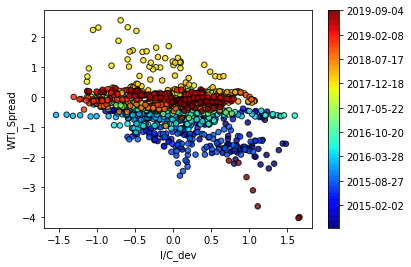

In [12]:
names = ['I/C_dev', 'WTI_Spread']
roll_name = 'WTI_2'
good = 'WTI_1'
draw_date_coloured_scatterplot(names, df[names])
names = ['WTI_Spread', 'I/C_dev']

In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#df[names]
df = df.dropna()
result = coint_johansen(df[names], 0, 1)
print("Trace Statistic:", result.lr1)
print("Trace Critical Values:", result.cvt)
print("Eigen Statistic:", result.lr2)
print("Eigen Critical Values:", result.cvm)

Trace Statistic: [57.518856    1.40094371]
Trace Critical Values: [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Eigen Statistic: [56.1179123   1.40094371]
Eigen Critical Values: [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


Stock WTI_1 and stock WTI_2 has a co-integration score of 0.0006
Stock WTI_1 and stock WTI_Spread has a co-integration score of 0.0016
Stock WTI_2 and stock WTI_Spread has a co-integration score of 0.0016
Stock I/C and stock I/C_MA10 has a co-integration score of 0.0
Stock WTI_Roll and stock I/C_MA10 has a co-integration score of 0.0
Stock WTI_Roll and stock I/C_dev has a co-integration score of 0.0


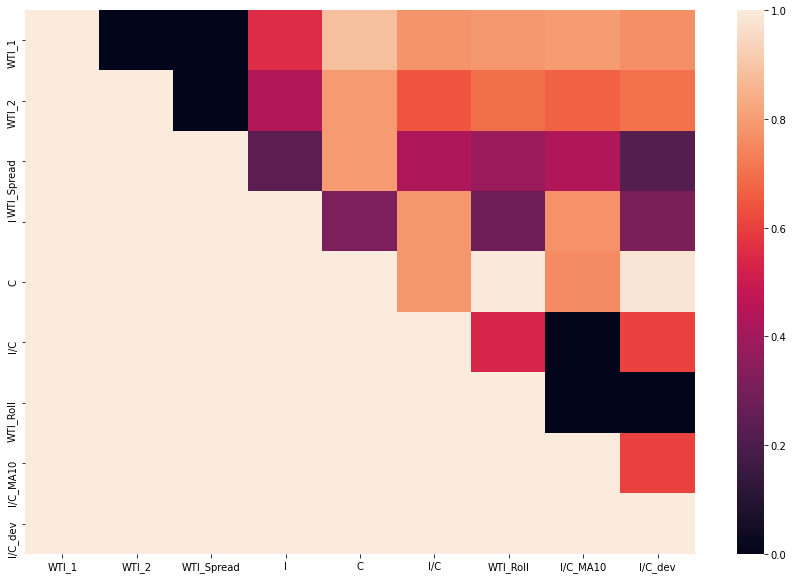

In [14]:
import statsmodels as sm
import seaborn as sns
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs
df_list = []
#not all stocks will return data so set up an empty list to store the stock tickers that actually successfully returns data
used_stocks = []

#run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix, pairs = find_cointegrated_pairs(df)
#convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)
#use Seaborn to plot a heatmap of our results matrix
fig, ax = plt.subplots(figsize=(15,10))
#used_stocks = df.index
sns.heatmap(pvalue_matrix_df,xticklabels=df.keys(),yticklabels=df.keys(),ax=ax)

for pair in pairs:
    print("Stock {} and stock {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

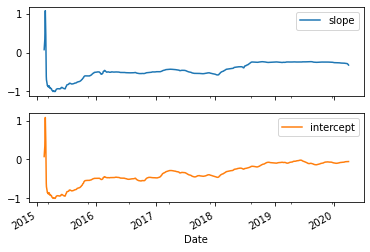

In [15]:
names = [ 'WTI_Spread', 'I/C_dev']
state_means, state_covs = calc_slope_intercept_kalman(names, df[names]) 
draw_slope_intercept_changes(df[names], state_means)

[ 0.07486439  0.34092156  0.63170688 ... -0.30194126 -0.3139269
 -0.32339096]
Results of Dickey-Fuller Test:
Test Statistic                   -5.432902
p-value                           0.000003
#Lags Used                       15.000000
Number of Observations Used    1263.000000
Critical Value (1%)              -3.435538
Critical Value (5%)              -2.863831
Critical Value (10%)             -2.567990
dtype: float64
Hurst Exponent 0.30561285430747165


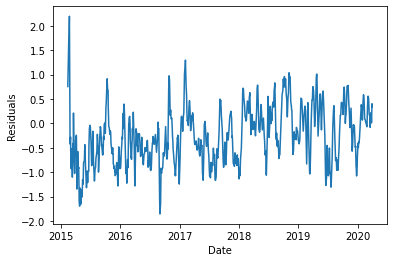

In [16]:
#print(pd.DataFrame(state_means)[0])
state_means0 = np.array(pd.DataFrame(state_means)[0])
print(state_means0)
resid = df[names[1]]-df[names[0]]*state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

adf_test(resid.dropna())

H, c,  drop = compute_Hc(resid.dropna())
print('Hurst Exponent', H)

length of state_mean:  1279
length of data:  1279
[0.9940043559354329, 0.9668793869049781, 0.9236907491775417, 0.88357343132165, 0.8002120791113159, 0.7302239606627524, 0.6776093975299115, 0.6007575106045994, 0.48456917744150413, 0.4028392401597184, 0.3772674956538606, 0.35389302390042315, 0.34354236775007585, 0.3315848274567432, 0.31891242238085393, 0.3121101633325794, 0.30329331534683296, 0.2937344305111938, 0.2800352181695851, 0.26505378437536786, 0.25166347184500143, 0.24756684138503024, 0.2405049844871725, 0.2383182474648951, 0.23818148829574212, 0.23498294782043522, 0.23257083859058578, 0.2305954324284557, 0.22839093802802513, 0.2261076725647779, 0.22313833425144008, 0.22020785071390095, 0.21796710834011834, 0.2169213260200022, 0.21602445685646895, 0.21574353160725454, 0.2147754052645921, 0.21244042739892316, 0.2089623877037184, 0.20594890660987228, 0.20454599905572143, 0.2042004161514196, 0.20356573045455853, 0.20221323947856235, 0.20123621455671156, 0.2007807919246374, 0.200148

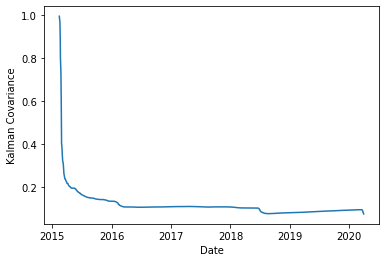

In [17]:
plt.plot(df.index, stdev)
plt.ylabel('Kalman Covariance')
plt.xlabel('Date')
print('length of state_mean: ', len(state_means0))
print('length of data: ', len(df[names[0]]))
print(stdev)

In [18]:
positions = [0]
trade = [0]
roll = df['WTI_Roll']
epsilon = 3
for i in range(1, len(resid)):
    if resid[i] < -stdev[i]*epsilon:
        positions.append(1)
        if positions[i-1] != 1:
            trade.append(1)
        else:
            trade.append(0)
    elif resid[i] > stdev[i]*epsilon:
        positions.append(-1)
        if positions[i-1] != -1:
            trade.append(1)
        else:
            trade.append(0)
    else:
        positions.append(0)
        if positions[i-1] != 0:
            trade.append(1)
        else:
            trade.append(0)
        

In [19]:

positions
print('Long positions:', positions.count(1))
print('Short positions:', positions.count(-1))
print('Neutral positions:', positions.count(0))

Long positions: 589
Short positions: 238
Neutral positions: 452


[3727999.9999999986,
 3727999.9999999986,
 3727999.9999999986,
 3727999.9999999986,
 4385999.999999998]

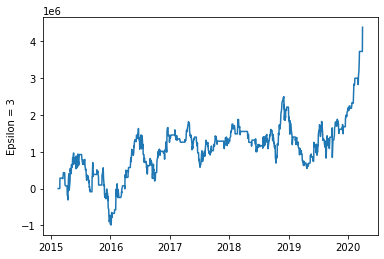

In [20]:
dFt = [0]
#print(data[names[0]][0])
for i in range(1,5):
    dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))
    #dFt.append(-1000*100*(data[good][i] - data[good][i-1]))


for i in range(5, len(resid)):
    if roll[i]:
        dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))
    elif roll[i-1]:
        dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
    elif roll[i-2]:
        dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
    elif roll[i-3]:
        dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
    elif roll[i-4]:
        dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
    elif roll[i-5]:
        dFt.append(1000*100*positions[i-1]*(data[good][i] - data[roll_name][i-1]))
    else:
        dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))

roll_PnL = [-1000]

for i in range(1, len(resid)):
    roll_PnL.append(roll_PnL[i-1]-2000*roll[i]*abs(positions[i])+dFt[i])


drawdown = [0]
for i in range(1,len(resid)):
    drawdown.append(max(roll_PnL[:i]) - roll_PnL[i])

plt.plot(df.index, roll_PnL)
plt.ylabel('Epsilon = 3')
roll_PnL[-5:]
#dFt[:20]


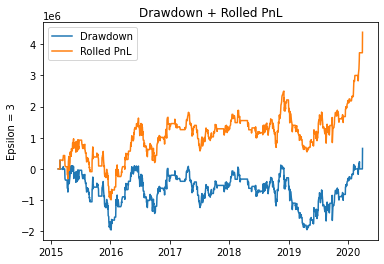

In [21]:
plt.plot(df.index, -1*np.array(drawdown))
plt.plot(df.index, roll_PnL)
plt.title("Drawdown + Rolled PnL")
plt.ylabel("Epsilon = 3")
plt.legend(['Drawdown', 'Rolled PnL'])

In [22]:
P_ann = roll_PnL[-1]/(6.25)
RoD = P_ann/max(drawdown)
SR = P_ann/(np.std(dFt)*math.sqrt(250))
print('P_ann:', P_ann)
print('RoD:', RoD)
print('SR:',SR)
print('Max DD', max(drawdown))

P_ann: 701759.9999999997
RoD: 0.3585896780786915
SR: 0.4721928339591992
Max DD 1957000.000000001


Text(0, 0.5, 'Annual PnL')

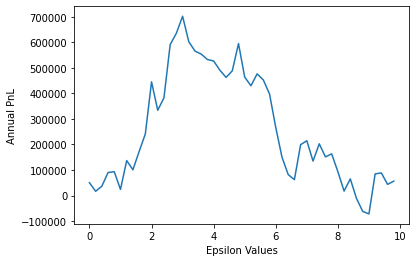

In [23]:
P_ann = []
RoD = []
SR = []
test = np.arange(0,10,0.2)
for epsilon in test:
    positions = [0]
    trade = [0]
    roll = df['WTI_Roll']

    for i in range(1, len(resid)):
        if resid[i] < -stdev[i]*epsilon:
            positions.append(1)
            if positions[i-1] != 1:
                trade.append(1)
            else:
                trade.append(0)
        elif resid[i] > stdev[i]*epsilon:
            positions.append(-1)
            if positions[i-1] != -1:
                trade.append(1)
            else:
                trade.append(0)
        else:
            positions.append(0)
            if positions[i-1] != 0:
                trade.append(1)
            else:
                trade.append(0)
    dFt = [0]
    #print(data[names[0]][0])
    for i in range(1,5):
        dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))
        #dFt.append(-1000*100*(data[good][i] - data[good][i-1]))


    for i in range(5, len(resid)):
        if roll[i]:
            dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))
        elif roll[i-1]:
            dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
        elif roll[i-2]:
            dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
        elif roll[i-3]:
            dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
        elif roll[i-4]:
            dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
        elif roll[i-5]:
            dFt.append(1000*100*positions[i-1]*(data[good][i] - data[roll_name][i-1]))
        else:
            dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))

    roll_PnL = [-1000]

    for i in range(1, len(resid)):
        roll_PnL.append(roll_PnL[i-1]-2000*roll[i]*abs(positions[i])+dFt[i])


    drawdown = [0]
    for i in range(1,len(resid)):
        drawdown.append(max(roll_PnL[:i]) - roll_PnL[i])
    Pann = roll_PnL[-1]/6.25
    P_ann.append(Pann)
    RoD.append(Pann/max(drawdown))
    SR.append(Pann/(np.std(dFt)*math.sqrt(250)))

plt.plot(test, P_ann)
plt.xlabel("Epsilon Values")
plt.ylabel("Annual PnL")

        

Text(0, 0.5, 'Sharpe Ratio')

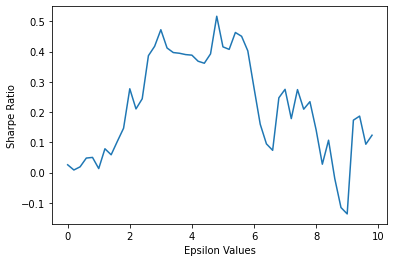

In [24]:
plt.plot(test, SR)
plt.xlabel("Epsilon Values")
plt.ylabel("Sharpe Ratio")
    

Text(0, 0.5, 'Return on Drawdown')

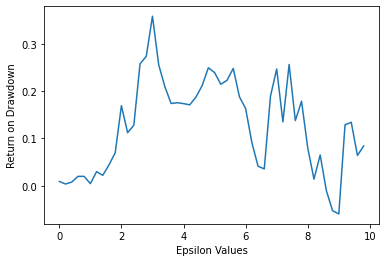

In [25]:
plt.plot(test, RoD)plt.xlabel("Epsilon Values")
plt.ylabel("Return on Drawdown")


               Comm Crude
Week of                  
2011-03-01  326080.285714
2011-03-02  326419.857143
2011-03-03  326759.428571
2011-03-04  327099.000000
                 Alaska
Week of                
2011-03-01  3342.714286
2011-03-02  3450.142857
2011-03-03  3557.571429
2011-03-04  3665.000000
Date
2011-03-31    0.638732
2011-04-01    0.639089
2011-04-04    0.640047
2011-04-05    0.640366
2011-04-06    0.640685
                ...   
2014-12-24    0.570382
2014-12-26    0.568408
2014-12-29    0.564596
2014-12-30    0.563327
2014-12-31    0.562059
Name: I/C, Length: 947, dtype: float64
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (

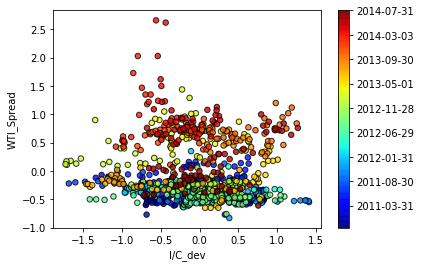

In [38]:
test = pd.read_csv('test.csv', parse_dates = ['Date'])
test.set_index(keys = 'Date', inplace = True)

Capacity = pd.read_csv('Capacity.csv', parse_dates=['Date'])
Capacity.set_index(keys = 'Date', inplace = True)
Capacity = Capacity['Sum of Working Storage Capacity and Stocks in Transit3'].resample('D')\
                .mean()
Capacity = Capacity.interpolate()
Capacity = Capacity

Capacity = Capacity[Capacity.index.isin(test.index)]
Capacity = Capacity.dropna()

Comm_Crude = pd.read_csv('Weekly_U.S._Ending_Stocks_excluding_SPR_of_Crude_Oil (1).csv', parse_dates = ['Week of'])
Comm_Crude.set_index(keys = 'Week of', inplace = True)
Comm_Crude = Comm_Crude.resample('D')\
                .mean()
Comm_Crude = Comm_Crude.interpolate()
Comm_Crude = Comm_Crude

Comm_Crude = Comm_Crude[Comm_Crude.index.isin(test.index)]
print(Comm_Crude.head(4))

transit = pd.read_csv('Weekly_U.S._Crude_Oil_Stocks_in_Transit_(on_Ships)_from_Alaska.csv', parse_dates = ['Week of'])
transit.set_index(keys = 'Week of', inplace = True)
transit = transit.resample('D')\
                .mean()
transit = transit.interpolate()
transit = transit

transit = transit[transit.index.isin(test.index)]
print(transit.head(4))

#df = np.divide(OECD,US)
#df = np.multiply(Crude_inventory, np.asarray(df))
df = pd.concat([test['WTI_1'], test['WTI_2']], axis = 1)
df['WTI_Spread'] = df['WTI_1'] - df['WTI_2']
#df['Inventory Change'] = df['US Crude'] - df['US Crude'].shift(-1)
df['I'] = np.add(transit, Comm_Crude)
df['C'] = Capacity
df = df.dropna()
df['I/C'] = np.divide(df['I'],df['C'])
#data = data[data.index.isin(df.index)]
df['WTI_Roll'] = test['WTI_Roll']
df['I/C_MA10'] = df['I/C'].rolling(window=10).mean()
print(df['I/C'])
#plt.plot(df['I/C'],df['WTI_Spread'], '.')
plt.ylabel('WTI Spread')
plt.xlabel('I/C')
df['I/C_dev'] = 100*(df['I/C'] - df['I/C_MA10'])
names = ['I/C_dev', 'WTI_Spread']
roll_name = 'WTI_2'
good = 'WTI_1'
draw_date_coloured_scatterplot(names, df[names])
names = ['WTI_Spread', 'I/C_dev']

In [42]:
df = df.dropna()
df 

WTI_1   WTI_2  WTI_Spread              I              C  \
Date                                                                   
2011-04-13  107.11  107.71       -0.60  339413.571429  531719.245902   
2011-04-14  108.11  108.70       -0.59  339127.285714  531768.803279   
2011-04-15  109.66  110.22       -0.56  338841.000000  531818.360656   
2011-04-18  107.12  107.69       -0.57  341148.000000  531967.032787   
2011-04-19  108.15  108.28       -0.13  341917.000000  532016.590164   
...            ...     ...         ...            ...            ...   
2014-12-24   55.84   56.22       -0.38  358626.571429  628747.675824   
2014-12-26   54.73   55.13       -0.40  357638.000000  629191.950549   
2014-12-29   53.61   54.03       -0.42  355615.571429  629858.362637   
2014-12-30   54.12   54.53       -0.41  354941.428571  630080.500000   
2014-12-31   53.27   53.70       -0.43  354267.285714  630302.637363   

                 I/C  WTI_Roll  I/C_MA10   I/C_dev  
Date                                                
2011-04-13  0.638332         1  0.639804 -0.147156  
2011-04-14  0.637734         0  0.639704 -0.196961  
2011-04-15  0.637137         0  0.639509 -0.237210  
2011-04-18  0.641295         0  0.639634  0.166174  
2011-04-19  0.642681         0  0.639865  0.281595  
...              ...       ...       ...       ...  
2014-12-24  0.570382         0  0.569769  0.061327  
2014-12-26  0.568408         0  0.570297 -0.188892  
2014-12-29  0.564596         0  0.570523 -0.592701  
2014-12-30  0.563327         0  0.570064 -0.673731  
2014-12-31  0.562059         0  0.569293 -0.723433  

[938 rows x 9 columns]

P_ann: -674400.0
RoD: -0.1711240801826946
SR: -0.5732783679755556
Max DD 3941000.0000000033


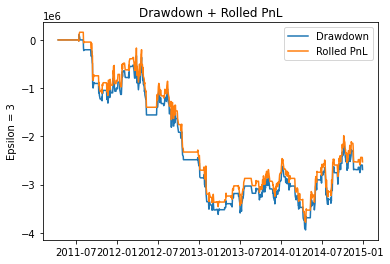

In [50]:
names = [ 'WTI_Spread', 'I/C_dev']
state_means, state_covs = calc_slope_intercept_kalman(names, df[names]) 
state_means0 = np.array(pd.DataFrame(state_means)[0])
resid = df[names[1]]-df[names[0]]*state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
positions = [0]
trade = [0]
roll = df['WTI_Roll']
epsilon = 3

for i in range(1, len(resid)):
    if resid[i] < -stdev[i]*epsilon:
        positions.append(1)
        if positions[i-1] != 1:
            trade.append(1)
        else:
            trade.append(0)
    elif resid[i] > stdev[i]*epsilon:
        positions.append(-1)
        if positions[i-1] != -1:
            trade.append(1)
        else:
            trade.append(0)
    else:
        positions.append(0)
        if positions[i-1] != 0:
            trade.append(1)
        else:
            trade.append(0)
        
    dFt = [0]
#print(data[names[0]][0])
for i in range(1,5):
    dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))
    #dFt.append(-1000*100*(data[good][i] - data[good][i-1]))


for i in range(5, len(resid)):
    if roll[i]:
        dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))
    elif roll[i-1]:
        dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
    elif roll[i-2]:
        dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
    elif roll[i-3]:
        dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
    elif roll[i-4]:
        dFt.append(1000*100*positions[i-1]*(data[roll_name][i] - data[roll_name][i-1]))
    elif roll[i-5]:
        dFt.append(1000*100*positions[i-1]*(data[good][i] - data[roll_name][i-1]))
    else:
        dFt.append(1000*100*positions[i-1]*(data[good][i] - data[good][i-1]))

roll_PnL = [-1000]

for i in range(1, len(resid)):
    roll_PnL.append(roll_PnL[i-1]-2000*roll[i]*abs(positions[i])+dFt[i])


drawdown = [0]
for i in range(1,len(resid)):
    drawdown.append(max(roll_PnL[:i]) - roll_PnL[i])
plt.plot(df.index, -1*np.array(drawdown))
plt.plot(df.index, roll_PnL)
plt.title("Drawdown + Rolled PnL")
plt.ylabel("Epsilon = 3")
plt.legend(['Drawdown', 'Rolled PnL'])

P_ann = roll_PnL[-1]/(3.75)
RoD = P_ann/max(drawdown)
SR = P_ann/(np.std(dFt)*math.sqrt(250))
print('P_ann:', P_ann)
print('RoD:', RoD)
print('SR:',SR)
print('Max DD', max(drawdown))


In [51]:

positions
print('Long positions:', positions.count(1))
print('Short positions:', positions.count(-1))
print('Neutral positions:', positions.count(0))

Long positions: 238
Short positions: 235
Neutral positions: 465


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a5bc59c6-88ac-4788-9570-1f7f1819cb4a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>